## Imports


In [1]:
import csv
import os
import random
import zipfile

from pathlib import Path 
from functools import partial
from typing import Callable, Any,List

import numpy as np 
import torch

from tqdm.notebook import tqdm
from data import get_challenge_points
from metrics import get_tpr_at_fpr
from midst_models.single_table_TabDDPM.wb_pipeline_utils import quantile_normalize_sklearn

In [2]:
import json

from midst_models.single_table_TabDDPM.wb_complex_pipeline import (
    clava_clustering,
    clava_training,
    clava_load_pretrained,
    clava_synthesizing,
    load_configs,
)
from midst_models.single_table_TabDDPM.wb_pipeline_modules import load_multi_table
from midst_models.single_table_TabDDPM.tab_ddpm.gaussian_multinomial_diffsuion import GaussianMultinomialDiffusion

In [3]:
TABDDPM_DATA_DIR = "tabddpm_white_box"
TABSYN_DATA_DIR = "tabsyn_white_box"

## Loading Model


In [4]:
# Load config
config_path = "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1/trans.json"
configs, save_dir = load_configs(config_path)

# Display config
json_str = json.dumps(configs, indent=4)
print(json_str)

{
    "general": {
        "data_dir": "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1",
        "exp_name": "",
        "workspace_dir": "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1",
        "sample_prefix": "",
        "test_data_dir": "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1"
    },
    "clustering": {
        "parent_scale": 1.0,
        "num_clusters": 50,
        "clustering_method": "both"
    },
    "diffusion": {
        "d_layers": [
            512,
            1024,
            1024,
            1024,
            1024,
            512
        ],
        "dropout": 0.0,
        "num_timesteps": 2000,
        "model_type": "mlp",
        "iterations": 200000,
        "batch_size": 4096,
        "lr": 0.0006,
        "gaussian_loss_type": "mse",
        "weight_decay": 1e-05,
        "scheduler": "cosine"
    },
    "classifier": {
        "d_layers": [


In [5]:
configs

{'general': {'data_dir': '/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1',
  'exp_name': '',
  'workspace_dir': '/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1',
  'sample_prefix': '',
  'test_data_dir': '/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1'},
 'clustering': {'parent_scale': 1.0,
  'num_clusters': 50,
  'clustering_method': 'both'},
 'diffusion': {'d_layers': [512, 1024, 1024, 1024, 1024, 512],
  'dropout': 0.0,
  'num_timesteps': 2000,
  'model_type': 'mlp',
  'iterations': 200000,
  'batch_size': 4096,
  'lr': 0.0006,
  'gaussian_loss_type': 'mse',
  'weight_decay': 1e-05,
  'scheduler': 'cosine'},
 'classifier': {'d_layers': [128, 256, 512, 1024, 512, 256, 128],
  'lr': 0.0001,
  'dim_t': 128,
  'batch_size': 4096,
  'iterations': 20000},
 'sampling': {'batch_size': 20000, 'classifier_scale': 1.0},
 'matching': {'num_matching_clusters': 1,
  'matching_batch_si

In [6]:
save_dir

'/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1/'

In [7]:
relation_order = [[None,'trans']]
models = clava_load_pretrained(relation_order,save_dir)

None -> trans checkpoint found, loading...


/home/vidit/.cache/pypoetry/virtualenvs/midst-models-qGUjvEOx-py3.9/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/vidit/.cache/pypoetry/virtualenvs/midst-models-qGUjvEOx-py3.9/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.5.0 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:
model = models[None,'trans']['diffusion']

In [9]:
device = "cuda"

In [10]:
model.to(device)

GaussianMultinomialDiffusion(
  (_denoise_fn): MLPDiffusion(
    (mlp): MLP(
      (blocks): ModuleList(
        (0): Block(
          (linear): Linear(in_features=128, out_features=512, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (1): Block(
          (linear): Linear(in_features=512, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (2): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (3): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dropout(p=0.0, inplace=False)
        )
        (4): Block(
          (linear): Linear(in_features=1024, out_features=1024, bias=True)
          (activation): ReLU()
          (dropout): Dro

## Making Functions for Quantile Regressors

In [11]:
# Imports 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [12]:
##############################
# Quantile Regressor Network #
##############################
import torch
import torch.nn as nn

class QuantileRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dims=[128, 64, 32]):
        super().__init__()
        layers = []
        for i in range(len(hidden_dims)):
            layers.append(nn.Linear(input_dim if i == 0 else hidden_dims[i - 1], hidden_dims[i]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))  # Dropout for regularization
        layers.append(nn.Linear(hidden_dims[-1], 1))  # Final output layer
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [13]:
# not using this code anymore, this one was generated by perplexity


# ##############################
# # Pinball Loss (Quantile Loss)#
# ##############################
# def pinball_loss(q_pred, target, alpha):
#     """
#     Computes the pinball (quantile) loss.
#     For each sample:
#       if target <= q_pred: loss = (q_pred - target) * (1 - alpha)
#       else:                loss = (q_pred - target) * (-alpha)
#     """
#     indicator = (target <= q_pred).float()
#     loss = (q_pred - target) * (indicator - alpha)
#     return loss.mean()

In [26]:
##############################
# Training Loop for a Model  #
##############################
from torch import nn, optim
import matplotlib.pyplot as plt

def train_quantile_regressor(model, data, labels, alpha, epochs=200, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data = data.to(device)
    labels = labels.to(device)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = lambda y_pred, y: torch.mean((y_pred - y) * ((y <= y_pred).float() - alpha))
    losses = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()  # Clear gradients at the start of each epoch
        outputs = model(data)
        loss = criterion(outputs.squeeze(), labels)
        losses.append(loss.item())
        #loss.backward()
        optimizer.step()
        
        # Detach the computation graph after each epoch
        outputs = outputs.detach()
        loss = loss.detach()

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


In [15]:
# this function is directly copied from earlier implementation

def compute_t_error(model, x, t):
    """
    Computes the reconstruction error at a specific timestep t.

    Args:
        model: Pretrained GaussianMultinomialDiffusion model.
        x: Input data tensor.
        t: Diffusion timestep (int or tensor).

    Returns:
        Reconstruction error tensor for each sample in x.
    """
    x_t = model.gaussian_q_sample(x_start=x, t=torch.tensor([t]).to(x.device))
        # Perform reverse denoising
    x_recon = model._denoise_fn(x_t, torch.tensor([t]).to(x.device))
    # Compute reconstruction error (e.g., L2 norm)
    t_error = torch.norm(x - x_recon, p=2, dim=1)
    return t_error

In [16]:
def perform_membership_inference(models, x, threshold_alpha):
    """
    Perform membership inference using reconstruction errors and a quantile regression model.
    """
    errors = compute_t_error(model, x, t=10)  # Example timestep
    thresholds = models(x)
    predictions = (errors <= thresholds).float()  # Membership decision
    return predictions

## Training Quantile Regressor

In [22]:
""" 
first write the code for getting normalized train_with_id data and then do the same for holdout_with_id then train two quantile regressor models, one on holdout error
and the other on train error, then if the error on the cp is less than holdout error then it is train point, or otherwise you can train the two quantile models and check
which distribution has the higher probability of containing the data point.
"""

' \nfirst write the code for getting normalized train_with_id data and then do the same for holdout_with_id then train two quantile regressor models, one on holdout error\nand the other on train error, then if the error on the cp is less than holdout error then it is train point, or otherwise you can train the two quantile models and check\nwhich distribution has the higher probability of containing the data point.\n'

### Loading & Normalizing Data

In [17]:
import pandas as pd
import torch
from tqdm import tqdm  # Import tqdm for progress tracking

def load_csv_as_tensor(file_path, nrows=None):
    df = pd.read_csv(file_path, header=None, nrows=nrows)  # Read without headers
    df = df.iloc[1:, 2:]  # Drop first two columns
    df = df.apply(pd.to_numeric, errors='coerce')  # Convert all values to numeric
    df = df.fillna(0)  # Replace NaNs with 0 (or use another strategy)
    return torch.tensor(df.values, dtype=torch.float32)  # Convert to tensor

# Load and process the first CSV file
file1 = "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1/train_with_id.csv"
tensor1 = load_csv_as_tensor(file1)

# Load and process the second CSV file (only first 20,000 rows)
file2 = "/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1/holdout_with_id.csv"  
tensor2 = load_csv_as_tensor(file2, nrows=20000)

In [18]:
print(tensor1.shape, tensor2.shape)

torch.Size([20000, 8]) torch.Size([19999, 8])


In [19]:
tensor1_nor, transformers_train = quantile_normalize_sklearn(tensor1.cpu().numpy())
tensor2_nor, transformers_holdout = quantile_normalize_sklearn(tensor1.cpu().numpy())

final_tensor1_nor = torch.tensor(tensor1_nor,dtype = torch.float32).to(device)
final_tensor2_nor = torch.tensor(tensor2_nor,dtype = torch.float32).to(device)

In [31]:
final_tensor = torch.cat((tensor1, tensor2), dim=0).to(device='cuda')
final_tensor_nor , transformers = quantile_normalize_sklearn(final_tensor.cpu().numpy())

In [32]:
print(final_tensor1_nor.shape)

torch.Size([20000, 8])


In [33]:
error_train = compute_t_error(model, final_tensor1_nor, t= 100)
error_holdout = compute_t_error(model,final_tensor2_nor,t = 100)

### Training Regressors

NOTE: Need to fix the training code of quantile regressor , currently loss.backward() has been commented

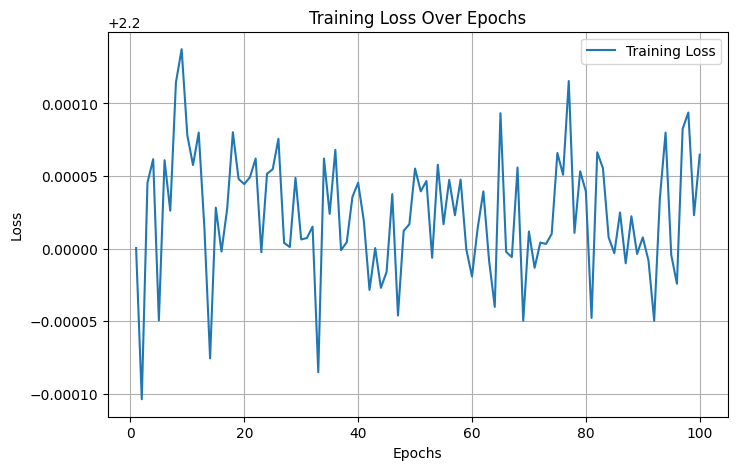

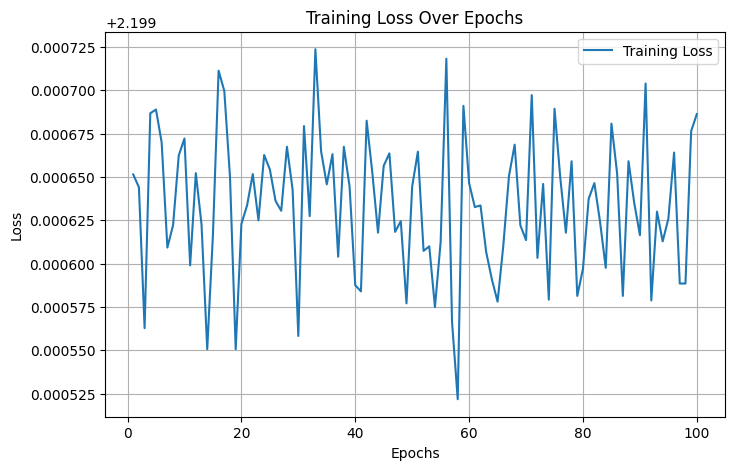

In [35]:
input_dim = 8
quantile_regressor_train = QuantileRegressor(input_dim=input_dim).to(device)

X_train  = final_tensor1_nor
y_train = error_train.to(device)

train_quantile_regressor(
    quantile_regressor_train,
    X_train,
    y_train,
    alpha=0.10,  # Set desired quantile (e.g., 5%)
    epochs= 100,
    lr=0.0005,
)

quantile_regressor_holdout = QuantileRegressor(input_dim=input_dim).to(device)

X_train  = final_tensor2_nor
y_train = error_holdout.to(device)

train_quantile_regressor(
    quantile_regressor_train,
    X_train,
    y_train,
    alpha=0.10,  # Set desired quantile (e.g., 5%)
    epochs= 100,
    lr=0.0005,
)


## Performing Inference on Challenge Points

In [36]:
test_data= load_csv_as_tensor("/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1/challenge_with_id.csv").to(device='cuda')
type(test_data)

torch.Tensor

In [37]:
test_data_nor_train = np.empty((test_data.shape[0], 0))
test_data = test_data.cpu().numpy()
for i in range(8):
    transformed_column = transformers[i].transform(test_data[:,i].reshape(-1,1))
    test_data_nor_train = np.concatenate((test_data_nor_train, transformed_column), axis=1)

final_test_data_nor_train = torch.tensor(test_data_nor_train,dtype = torch.float32).to(device)

test_data_nor_holdout = np.empty((test_data.shape[0], 0))
test_data = test_data
for i in range(8):
    transformed_column = transformers[i].transform(test_data[:,i].reshape(-1,1))
    test_data_nor_holdout = np.concatenate((test_data_nor_holdout, transformed_column), axis=1)

final_test_data_nor_holdout = torch.tensor(test_data_nor_holdout,dtype = torch.float32).to(device)

In [38]:
print(final_test_data_nor_train.shape, final_test_data_nor_holdout.shape)

torch.Size([200, 8]) torch.Size([200, 8])


In [39]:
pred_error_train = quantile_regressor_train(final_test_data_nor_train)
pred_error_holdout = quantile_regressor_holdout(final_test_data_nor_holdout)
actual_error = compute_t_error(model,final_test_data_nor_train,t = 100)

print(pred_error_train.shape,pred_error_train.shape,actual_error.shape)

torch.Size([200, 1]) torch.Size([200, 1]) torch.Size([200])


In [41]:
challenge_labels = pd.read_csv("/home/vidit/Desktop/SaTML/MIDSTModels/starter_kits/tabddpm_white_box/train/tabddpm_1/challenge_label.csv")
challenge_ground_truth = challenge_labels["is_train"].values

In [43]:
print(actual_error)

tensor([47.5503, 25.4928, 21.4764, 14.5178, 21.9812, 11.4569, 23.3856, 11.7835,
        16.7310, 15.6057, 23.3268, 23.7621, 25.9202, 24.1391, 24.4179, 16.4903,
        25.9845, 27.9974, 15.1685, 13.8474,  9.4349, 26.2240, 14.8456, 22.8487,
        22.7658, 13.2550, 15.8788, 21.8791, 23.4597, 21.6899, 51.9968, 22.6137,
        22.8898, 28.1154, 22.3738, 25.1469, 26.1007, 25.0651, 15.0899, 14.5454,
        11.2120, 13.8468, 15.2115, 23.5141, 23.5156, 10.9404, 14.4369, 24.9958,
        22.1041, 16.4609, 31.2824, 27.2031, 24.8256, 29.3989, 19.8008,  9.9913,
        22.9205, 22.9644, 15.7125, 21.0576, 26.6560, 21.4565, 21.6143, 22.7474,
        14.3224, 23.8048, 22.6153, 24.1062, 23.8828, 26.5109, 24.5772, 24.1039,
        58.4432, 15.1544, 65.1246, 22.0831, 22.5388, 13.8277, 20.5533, 19.9217,
        16.0503, 15.7817, 55.3135, 13.2048, 27.0598, 23.0508, 16.0915, 21.3524,
        21.1766, 15.5650, 23.7942, 14.7662, 21.9251, 25.7871, 27.8251, 10.6854,
        14.8015, 14.9940,  9.6856, 23.89

In [42]:
prediction_scores = pred_error_train * pred_error_holdout
prediction_scores.shape

torch.Size([200, 1])

In [44]:
membership_predictions = (prediction_scores > 0.5).float().cpu().numpy()
membership_predictions

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
fpr, tpr, thresholds = roc_curve(challenge_ground_truth, prediction_scores.detach().cpu().numpy())

# Find the threshold where FPR is closest to 0.1
fpr_target = 0.1
idx = (fpr <= fpr_target).sum() - 1  # Find the index of the last FPR <= 0.1
tpr_at_fpr_target = tpr[idx] if idx >= 0 else 0

print(f"True Positive Rate at 10% False Positive Rate: {tpr_at_fpr_target:.4f}")

True Positive Rate at 10% False Positive Rate: 0.0900


In [123]:
from sklearn.metrics import accuracy_score, roc_curve

# Example inputs (replace with actual data)
y_true = challenge_ground_truth  # Binary labels (0 or 1)
y_pred = predictions  # Predicted scores (continuous)

# Compute Accuracy
y_pred_labels = (y_pred >= 0.5).astype(int)  # Convert scores to binary labels
accuracy = accuracy_score(y_true, y_pred_labels)

# Compute TPR at the closest FPR to 10%
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
closest_idx = np.argmin(np.abs(fpr - 0.1))  # Find the index where FPR is closest to 10%
tpr_at_10_fpr = tpr[closest_idx]

# Print Results
print(f"Accuracy: {accuracy:.4f}")
print(f"TPR at 10% FPR: {tpr_at_10_fpr:.4f}")

Accuracy: 0.5750
TPR at 10% FPR: 0.0000


### Deprecated Code from perplexity

In [122]:
# predictions = []
# for i in range(test_data.shape[0]):
#     train_err = pred_error_train[i].item()
#     holdout_err = pred_error_holdout[i].item()
#     actual_err = actual_error[i].item()
#     classification = 0 if (abs(actual_err - train_err) > abs(actual_err - holdout_err)) else 1
#     predictions.append(classification)

# print(predictions)

[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1]


In [ ]:

    
    # # =============================================================================
    # # Inference: For each test sample, use the trained model to predict a threshold.
    # # Compare the actual score to the threshold to decide membership:
    # # If actual score <= predicted threshold, output 1 (member); else, output 0 (nonmember).
    # # =============================================================================
    # output_list = []
    # for sample in test_tensor:
    #     x_sample = sample[:input_dim].unsqueeze(0)  # shape: [1, input_dim]
    #     actual_score = sample[input_dim].item()       # the observed score for this sample
    #     model.eval()
    #     with torch.no_grad():
    #         pred_threshold = model(x_sample).item()
    #     decision = 1 if actual_score <= pred_threshold else 0
    #     output_list.append(decision)
    
    # # Create a tensor of output predictions.
    # output = torch.tensor(output_list)
    
    # print("\nFinal membership predictions (1 = member, 0 = nonmember):")
    # print(output)
